<h2><b>Main task analysis</b></h2>
<p>Takes the summary table from the task analysis and tests H1a - <b>regressive errors are reduced and perseverative errors are increased in disgust learning</b></
<p> Includes:</p>
<li>Hypothesis testing
<li>Model assumption tests 
<li>Adding covariates and random effects --> random intercepts for fractals and videos used in the task (feedback_randint) and by-participant random slopes; age, sex and working memory covariates
<li>Adding video rating scores
<li>Bayesian t-tests to assess strength of any null findings
<li>Follow-up, win-stay/lose-shift analyses

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import jsonlines
from functools import reduce
import statistics
import scipy.stats
import seaborn as sns
import math
import os
import json
import ast
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.bayes_mixed_glm import PoissonBayesMixedGLM
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

import pingouin as pg
import warnings
from scipy.stats import ttest_rel
#from statannotations.Annotator import Annotator
from scipy.stats import skew
from statsmodels.stats.diagnostic import het_white
from sklearn.preprocessing import PowerTransformer
import statannot
from scipy.stats import ttest_ind
import itertools
from dataclean_func import *
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.copy_on_write = True

In [2]:
task_summary=pd.read_csv('csvs/dem_vids_task_excluded.csv')

In [3]:
task_summary

,Unnamed: 0,percentage_correct,mean_perseverative_er,mean_regressive_er,median_till_correct,mean_till_correct,win_stay,lose_shift,timed_out,block_no,...,unspecified,digit_span,prolific_age,prolific_sex,prolific_MH,time taken,self_report_gender,self_report_assigned-at-birth,self_report_age,aligns
0,0,0.716418,1.142857,0.428571,8.0,8.428571,0.951220,0.520000,0,1.0,...,0,8.0,61,Female,No,43.616667,Female,Yes,61,True
1,1,0.875000,0.000000,0.285714,6.0,6.142857,1.000000,0.733333,0,2.0,...,0,8.0,61,Female,No,43.616667,Female,Yes,61,True
2,2,0.757143,0.714286,0.857143,10.0,9.285714,1.000000,0.739130,0,3.0,...,0,8.0,61,Female,No,43.616667,Female,Yes,61,True
3,3,0.753086,0.285714,1.714286,12.0,10.857143,0.947368,0.782609,0,2.0,...,0,6.0,52,Male,No,40.283333,Male,Yes,52,True
4,4,0.634615,1.000000,3.142857,13.0,13.428571,0.937500,0.641026,0,1.0,...,0,6.0,52,Male,No,40.283333,Male,Yes,52,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,1207,0.758065,0.428571,0.857143,6.0,8.142857,0.954545,0.529412,0,1.0,...,0,7.0,47,Female,Yes,95.150000,Female,Yes,47,True
1016,1208,0.535000,1.571429,9.857143,17.0,25.000000,0.669811,0.483871,1,3.0,...,0,7.0,47,Female,Yes,95.150000,Female,Yes,47,True
1017,1212,0.723577,0.000000,4.000000,12.0,16.714286,0.862500,0.738095,0,3.0,...,0,9.0,64,Male,No,50.083333,Male,Yes,64,True
1018,1213,0.683333,0.714286,3.571429,13.0,15.285714,0.942029,0.780000,0,1.0,...,0,9.0,64,Male,No,50.083333,Male,Yes,64,True


<h3><b>Main hypothesis test</b></h3>
<p>Testing whether there are differences in perseverative and regressive errors across block type </p>
<p>Models to run: </p>
<li> 1) 'mean_perseverative_er ~ block_type'
<li> 2) 'mean_regressive_er ~ block_type'

<b> MODEL 1: PERSEVERATIVE ERRORS </b>

Firstly - check the outcome for skewness

Perseverative error skew: 2.400818032551747


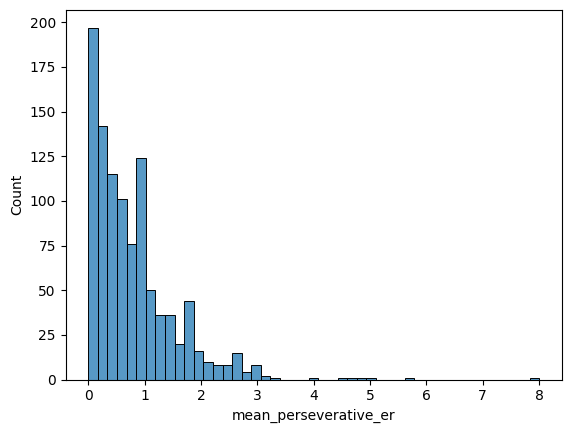

In [4]:
sns.histplot(data=task_summary, x="mean_perseverative_er") 
print('Perseverative error skew: '+str(skew(task_summary.mean_perseverative_er)))
#is a skew so need to correct the skew

<Axes: xlabel='perseverative_er_transformed', ylabel='Count'>

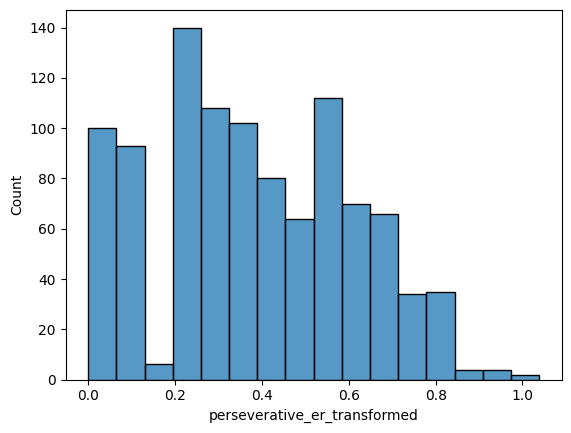

In [5]:
#All further analyses will be done on this transformed variable
pt=PowerTransformer(method='yeo-johnson', standardize=False)
skl_yeojohnson=pt.fit(pd.DataFrame(task_summary.mean_perseverative_er))
skl_yeojohnson=pt.transform(pd.DataFrame(task_summary.mean_perseverative_er))
task_summary['perseverative_er_transformed'] = pt.transform(pd.DataFrame(task_summary.mean_perseverative_er))
sns.histplot(data=task_summary['perseverative_er_transformed'])

<b>Now run the initial hypothesis testing models</b>
<p>Will test the fit of models with different random and fixed effects before determining which model to use for hypothesis testing:

<b>H1a</b> Effect of feedback-type on perseverative error

In [6]:
data=task_summary.reset_index()

formula = 'perseverative_er_transformed ~ block_type'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

In [7]:
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [8]:
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [9]:
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [10]:
feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


   basic_model     feedback_randint     fractals_randint  \
0  -156.851283  CONVERGENCE WARNING  CONVERGENCE WARNING   

   feedback_fractals_randint   randslope feedback_randint_randslope  \
0                 -78.173486 -128.487069        CONVERGENCE WARNING   

  feedback_fractals_randint_randslope  
0                 CONVERGENCE WARNING  


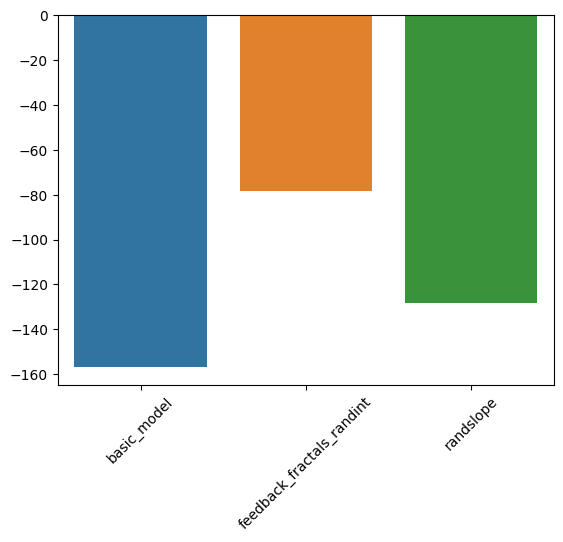

In [11]:
#test which random effects to include
#feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False) CONVERGENCE WARNING
#fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False) CONVERGENCE WARNING
feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
#feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False) CONVERGENCE WARNING
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False) CONVERGENCE WARNING


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_randint': ['CONVERGENCE WARNING'], 
                    'fractals_randint': ['CONVERGENCE WARNING'],
                    'feedback_fractals_randint': [feedback_fractals_randint.bic], ##added manually
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':['CONVERGENCE WARNING'],
                    'feedback_fractals_randint_randslope': ['CONVERGENCE WARNING']})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, basic model is the best

   no_covariate  age_covariate  digit_span_covariate  sex_covariate  \
0   -156.851283    -152.183759           -150.380937    -150.198921   

   sex_age_covariate  digit_span_age_covariate  sex_digit_span_covariate  \
0        -145.567838               -145.463878               -143.826925   

   sex_age_digit_span_covariate  
0                   -138.917108  


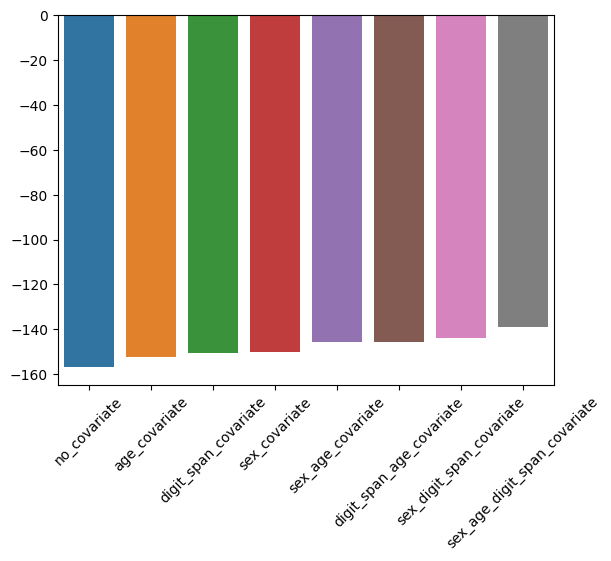

In [12]:
##test which covariates to add -- Using the random effects which were best above (basic model in this case)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
plt.xticks(rotation=45)
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1))  ##in this case, nocovariate is the best

In [13]:
#Hypothesis test using this model (and if no covariate model hadn't won - would run this too)
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:            MixedLM Dependent Variable: perseverative_er_transformed
No. Observations: 1020    Method:             ML                          
No. Groups:       340     Scale:              0.0375                      
Min. group size:  3       Log-Likelihood:     95.7445                     
Max. group size:  3       Converged:          Yes                         
Mean group size:  3.0                                                     
----------------------------------------------------------------------------
                        Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
----------------------------------------------------------------------------
Intercept                0.405      0.012   32.755   0.000    0.381    0.430
block_type[T.Fear]      -0.022      0.015   -1.470   0.141   -0.051    0.007
block_type[T.Points]    -0.028      0.015   -1.873   0.061   -0.057    0.001
Group Var                0.015      0.013                                   
==========================================================================

"""

<h4>Test the assumptions of the final model</h4> 
<p>The model we are basing our conclusions on

In [14]:
#checking assumptions 
#chose model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9931933132269517
p-value 0.00012825572082599747
LM Statistic 5.332021820867592
LM-Test p-value 0.06952903037179446
F-Statistic 2.672138230652338
F-Test p-value 0.06958948752634543


Assumptions are violated - so need to try a generalised mixed effects model
<p><b>For this, see perseverative_ers.ipynb notebook</b></p>
<p>This is a separate notebook because the model is run using R rather than python</p>
<p>Results of this model finds a significant difference between disgust and points, but not between disgust and fear

<h4>Computing Bayes factor to see strength of the null</h4>
<li>As there is no difference between fear and disgust in the generalized model, we will compute a Bayes factor to determine the strength of that null.
<br>
<br>
<p>Will interpret this bayes factor using Figure 4 from:
<p>Van Doorn, Johnny & van den Bergh, Don & Boehm, Udo & Dablander, Fabian & Derks, Koen & Draws, Tim & Evans, Nathan & Gronau, Quentin & Hinne, Max & Kucharský, Šimon & Ly, Alexander & Marsman, Maarten & Matzke, Dora & Raj, Akash & Sarafoglou, Alexandra & Stefan, Angelika & Voelkel, Jan & Wagenmakers, Eric-Jan. (2019). The JASP Guidelines for Conducting and Reporting a Bayesian Analysis. Psychonomic Bulletin and Review. 10.3758/s13423-020-01798-5

In [15]:
##create a function to do this using the pinguouin package
        #NB for simplicity just doing pair-wise t-tests for key conditions
        #has been updated since stage one to make more streamline/understandable - outputs are the same as before
def bayes_factor(df, dependent_var, condition_1_name, condition_2_name):
    df=df[(df.block_type==condition_1_name)| (df.block_type==condition_2_name)][[dependent_var, 'block_type', 'participant_no']]
    df.dropna(inplace=True)
    df=df.pivot(index='participant_no', columns='block_type', values=dependent_var).reset_index()
    ttest=pg.ttest(df[condition_1_name], df[condition_2_name], paired=True)
    bf_null=1/float(ttest.BF10)
    return bf_null

In [16]:
bayes_factor(task_summary, 'perseverative_er_transformed', 'Disgust', 'Fear')

6.369426751592357

In [17]:
bayes_factor(task_summary, 'perseverative_er_transformed', 'Points', 'Fear')

14.925373134328357

<b> MODEL 2: REGRESSIVE ERRORS </b>
<p> Same again but with regressive rather than perseverative errors</p>
<p> This time I have made the outcome variable skewed so show how this would be dealt with </p>

Firstly - check the outcome for skewness

Regressive error skew: 6.465682277497517


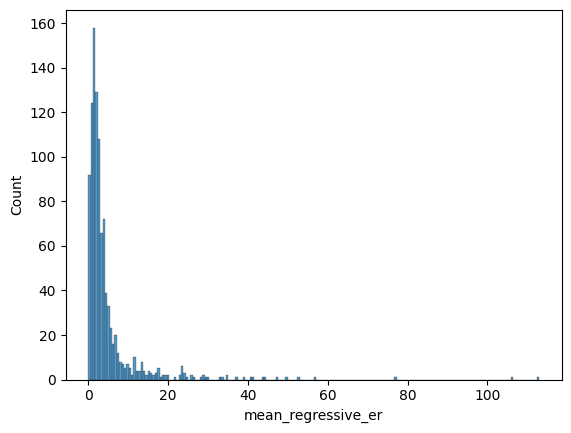

In [18]:
##Model assumptions - skew of distribution
    #data was created to be a skewed distribution - so skew value >0.5
sns.histplot(data=task_summary, x="mean_regressive_er") 
print('Regressive error skew: '+str(skew(task_summary.mean_regressive_er,  nan_policy='omit')))

Given that the distribution was skewed, must perform a transformation

<Axes: xlabel='regressive_er_transformed', ylabel='Count'>

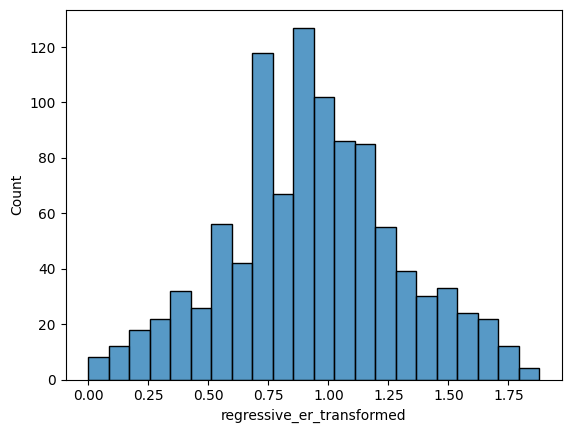

In [19]:
#All further analyses will be done on this transformed variable
pt=PowerTransformer(method='yeo-johnson', standardize=False)
skl_yeojohnson=pt.fit(pd.DataFrame(task_summary.mean_regressive_er))
skl_yeojohnson=pt.transform(pd.DataFrame(task_summary.mean_regressive_er))
task_summary['regressive_er_transformed'] = pt.transform(pd.DataFrame(task_summary.mean_regressive_er))
sns.histplot(data=task_summary['regressive_er_transformed'])

<b>Now run the hypothesis testing model on the transformed variable</b>
<p><p>Will test the fit of models with different random and fixed effects before determining which model to use for hypothesis testing (as with above):

In [20]:
data=task_summary.reset_index()

formula = 'regressive_er_transformed ~ block_type'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

In [21]:
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [22]:
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [23]:
feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


   basic_model      feedback_andint     fractals_randint  \
0   565.219279  CONVERGENCE WARNING  CONVERGENCE WARNING   

   feedback_fractals_randint   randslope  feedback_randint_randslope  \
0                 839.056473  597.273718                  604.201273   

  feedback_fractals_randint_randslope  
0                 CONVERGENCE WARNING  


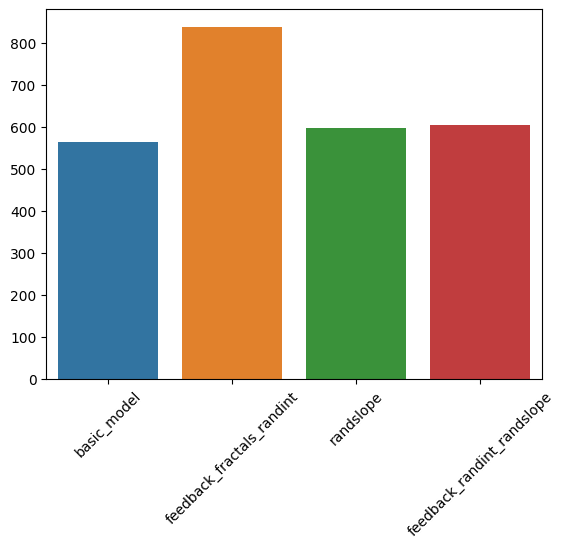

In [24]:
#test which random effects to include
#feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False) CONVERGENCE WARNING
#fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False) CONVERGENCE WARNING
feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False) CONVERGENCE WARNING


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_andint': ['CONVERGENCE WARNING'], 
                    'fractals_randint': ['CONVERGENCE WARNING'],
                    'feedback_fractals_randint': [feedback_fractals_randint.bic],
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': ['CONVERGENCE WARNING']})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, basic model is the best

   no_covariate  digit_span_covariate  age_covariate  sex_covariate  \
0    565.219279            571.233493     571.369947      571.53967   

   digit_span_age_covariate  sex_digit_span_covariate  sex_age_covariate  \
0                577.604063                577.712807         577.717403   

   sex_age_digit_span_covariate  
0                     584.08551  


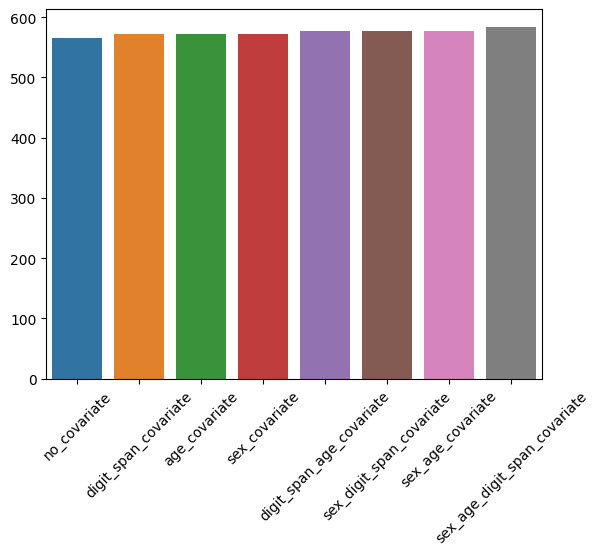

In [25]:
##test which covariates to add -- Using the random effects which were best above (basic model in this case)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
plt.xticks(rotation=45) 
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, nocovariate is the best

In [26]:
#Hypothesis test using this model (and if no covariate model hadn't won - would run this too)
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:            MixedLM Dependent Variable: regressive_er_transformed
No. Observations: 1020    Method:             ML                       
No. Groups:       340     Scale:              0.0602                   
Min. group size:  3       Log-Likelihood:     -265.2907                
Max. group size:  3       Converged:          Yes                      
Mean group size:  3.0                                                  
------------------------------------------------------------------------
                         Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------------------
Intercept                 0.933     0.019  48.088  0.000   0.895   0.971
block_type[T.Fear]        0.006     0.019   0.313  0.755  -0.031   0.043
block_type[T.Points]     -0.001     0.019  -0.050  0.960  -0.038   0.036
Group Var                 0.068     0.034                               
=======================================================================

"""

Test the assumptions of this final model

In [27]:
#again checking assumptions
#chose model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.993953373902031
p-value 0.00038660283099416264
LM Statistic 1.6807974760241717
LM-Test p-value 0.43153841834787054
F-Statistic 0.8393100262077964
F-Test p-value 0.43230750732223955


Non-normality of residuals violates assumptions - so see regressive_ers.ipynb for generalized mixed effects model

Compute the Bayes factors for any null finding

In [28]:
bayes_factor(task_summary, 'regressive_er_transformed', 'Disgust', 'Points')

16.39344262295082

In [29]:
bayes_factor(task_summary, 'regressive_er_transformed', 'Disgust', 'Fear')

15.625

In [30]:
bayes_factor(task_summary, 'regressive_er_transformed', 'Fear', 'Points')

15.384615384615383

<h3><b>Adding video ratings</b></h3>
<p>Testing whether this result is modified by adding video ratings: </p>
<p>=models 3 and 4 in the analysis plan
<p><b>ONLY TO BE RUN IF RESULTS OF VIDEO RATINGS WARRANT IT</b>
<li>If there is a difference in valence and arousal across fear and disgusting videos: add this difference as a covariate (fear(T1)-disgust(T1))
<li>If there is a difference in habituation between fear and disgusting videos: add this difference in habituation as a covariate (Fear(T1-T2) - Disgust(T1-T2))

<b> MODEL 3: PERSEVERATIVE ERRORS W VIDEO RATINGS </b>

In [31]:
#e.g., if there was a difference in valence habituation and baseline arousal
# identified by a difference in valence habituation (valence_habdiff)
        #i.e., a time*stimulus type interaction in valence model (model A)
# and an effect of stimulus type in arousal model (model B)
#so add valence_habdiff and arousal_diff to the model as covariates

data=task_summary.reset_index()

formula = 'perseverative_er_transformed ~ block_type + +valence_diff + arousal_diff + valence_habdiff'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

In [32]:
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [33]:
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [34]:
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [35]:
feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


   basic_model      feedback_andint     fractals_randint  \
0  -139.829322  CONVERGENCE WARNING  CONVERGENCE WARNING   

  feedback_fractals_randint   randslope feedback_randint_randslope  \
0       CONVERGENCE WARNING -111.599128        CONVERGENCE WARNING   

  feedback_fractals_randint_randslope  
0                 CONVERGENCE WARNING  


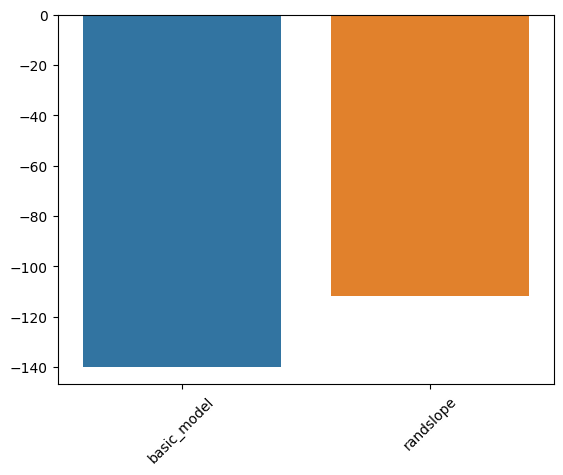

In [36]:
#test which random effects to include
#feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False) CONVERGENCE WARNING
#fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False) CONVERGENCE WARNING
#feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
#feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False) CONVERGENCE WARNING
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False) CONVERGENCE WARNING
        

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_andint': ['CONVERGENCE WARNING'], 
                    'fractals_randint': ['CONVERGENCE WARNING'],
                    'feedback_fractals_randint': ['CONVERGENCE WARNING'],
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':['CONVERGENCE WARNING'],
                    'feedback_fractals_randint_randslope': ['CONVERGENCE WARNING']})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, basic model is the best

   no_covariate  age_covariate  digit_span_covariate  sex_covariate  \
0   -139.829322    -134.509382           -133.411158    -133.164219   

   sex_age_covariate  digit_span_age_covariate  sex_digit_span_covariate  \
0         -127.87741               -127.868026               -126.848509   

   sex_age_digit_span_covariate  
0                   -121.315358  


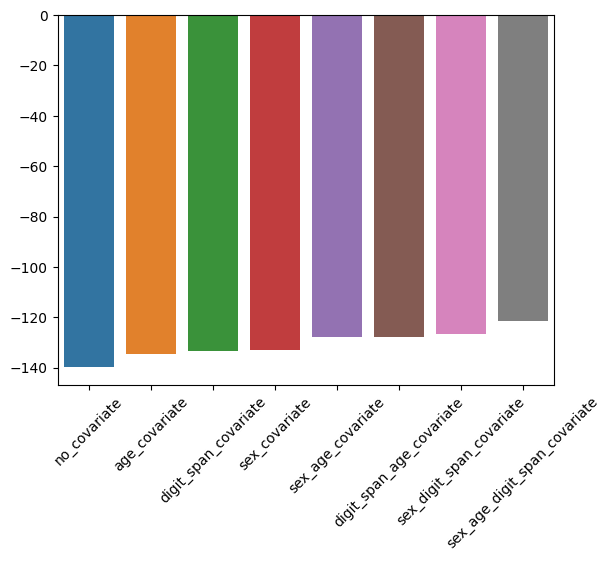

In [37]:
##test which covariates to add -- Using the random effects which were best above (basic model in this case)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
plt.xticks(rotation=45) 
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, no covariate

In [38]:
#Hypothesis test using this model (and if no covariate model hadn't won - would run this too)
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:            MixedLM Dependent Variable: perseverative_er_transformed
No. Observations: 1020    Method:             ML                          
No. Groups:       340     Scale:              0.0375                      
Min. group size:  3       Log-Likelihood:     97.6249                     
Max. group size:  3       Converged:          Yes                         
Mean group size:  3.0                                                     
----------------------------------------------------------------------------
                        Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
----------------------------------------------------------------------------
Intercept                0.406      0.014   29.076   0.000    0.379    0.433
block_type[T.Fear]      -0.022      0.015   -1.470   0.141   -0.051    0.007
block_type[T.Points]    -0.028      0.015   -1.873   0.061   -0.057    0.001
valence_diff            -0.004      0.006   -0.769   0.442   -0.015    0.007
arousal_diff            -0.012      0.008   -1.602   0.109   -0.027    0.003
valence_habdiff          0.001      0.004    0.264   0.792   -0.007    0.010
Group Var                0.014      0.013                                   
==========================================================================

"""

In [39]:
#again checking assumptions

#chose model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9932531693384103
p-value 0.0001396501655398863
LM Statistic 25.632636798829374
LM-Test p-value 0.08141864106695888
F-Statistic 1.5193758613542114
F-Test p-value 0.08025252693260077


As before, model assumptions here are violated - so a generalized mixed effects model has been run in (perseverative_ers_wVideoRatings.ipynb notebook)
<p>This model finds that the difference between disgust and points found in the original model is not moderated by the video rating differences between fear and disgust</p>

<b> MODEL 4: REGRESSIVE ERRORS W VIDEO RATINGS </b>

Do the same for regressive errors

In [40]:
#e.g., same scenario as above
#note still using transformed outcome variable (as it is skewed)

formula = 'regressive_er_transformed ~ block_type + valence_diff + arousal_diff + valence_habdiff'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

In [41]:
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [42]:
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [43]:
#commented out as gives error
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)

   basic_model      feedback_andint     fractals_randint  \
0   585.869188  CONVERGENCE WRANING  CONVERGENCE WARNING   

   feedback_fractals_randint   randslope  feedback_randint_randslope  \
0                 859.565855  617.884096                   624.81165   

  feedback_fractals_randint_randslope  
0                 CONVERGENCE WARNING  


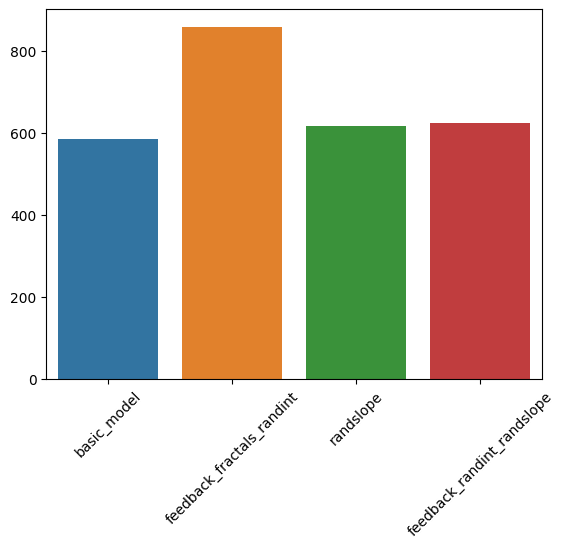

In [44]:
#test which random effects to include
#feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False) CONVERGENCE WARNING
#fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False) CONVERGENCE WARNING
feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_andint': ['CONVERGENCE WRANING'], 
                    'fractals_randint': ['CONVERGENCE WARNING'],
                    'feedback_fractals_randint': [feedback_fractals_randint.bic], 
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': ['CONVERGENCE WARNING']})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, basic model is the best
        #if two models have the same BIC we got for the simplest model (models are in order of simplicity)

   no_covariate  digit_span_covariate  age_covariate  sex_covariate  \
0    585.869188             591.90699     592.096708      592.18391   

   digit_span_age_covariate  sex_digit_span_covariate  sex_age_covariate  \
0                598.334841                598.380364         598.440486   

   sex_age_digit_span_covariate  
0                    604.813154  


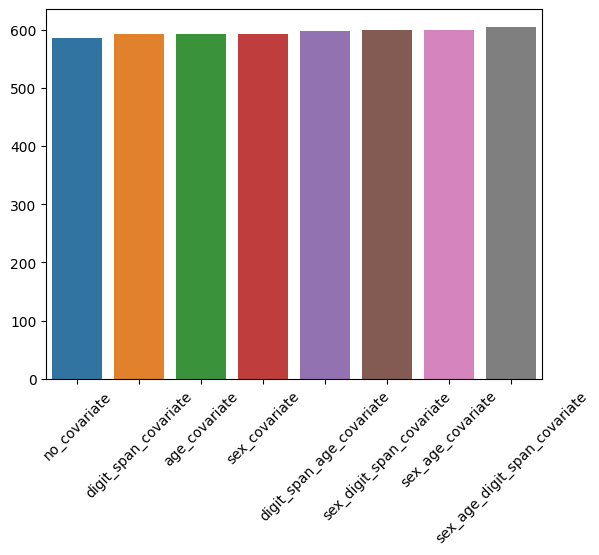

In [45]:
##test which covariates to add -- Using the random effects which were best above (basic model in this case)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
plt.xticks(rotation=45) 
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, no covariate is best
    

In [46]:
#hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:            MixedLM Dependent Variable: regressive_er_transformed
No. Observations: 1020    Method:             ML                       
No. Groups:       340     Scale:              0.0602                   
Min. group size:  3       Log-Likelihood:     -265.2244                
Max. group size:  3       Converged:          Yes                      
Mean group size:  3.0                                                  
------------------------------------------------------------------------
                         Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------------------
Intercept                 0.934     0.023  41.090  0.000   0.889   0.978
block_type[T.Fear]        0.006     0.019   0.313  0.755  -0.031   0.043
block_type[T.Points]     -0.001     0.019  -0.050  0.960  -0.038   0.036
valence_diff             -0.001     0.010  -0.109  0.913  -0.021   0.019
arousal_diff             -0.004     0.014  -0.281  0.779  -0.031   0.023
valence_habdiff          -0.001     0.008  -0.136  0.891  -0.016   0.014
Group Var                 0.068     0.034                               
=======================================================================

"""

In [47]:
#again checking assumptions
#chose model
results=no_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)
#
for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9939763341744763
p-value 0.0004000161055989432
LM Statistic 21.01232718923764
LM-Test p-value 0.22573937517352236
F-Statistic 1.239746313819834
F-Test p-value 0.22572279544931717


Assumption is violated so see - regressive_ers_wVideoRatings.ipynb for generalized model

<h3><b>Win-stay/lose-shift analyses</b></h3>
<p>Only to be run if there are differences in regressive or perseverative errors across the block types (significant effects of block type in models 1 or 2)</p>
<p>Models to run: </p>
<li> 5) 'win_stay ~ block_type + any covariates that were significant in models 1 and 2'
<li> 6) 'lose_shift ~ block_type + any covariates that were significant in models 1 and 2'

<b> MODEL 5: WIN-STAY </b>

Win-stay  skew: -1.4392950153974455


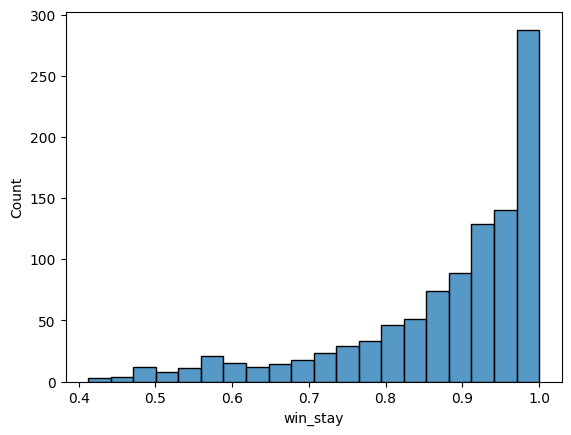

In [48]:
sns.histplot(data=task_summary, x="win_stay") 
print('Win-stay  skew: '+str(skew(task_summary.win_stay)))

<Axes: xlabel='win_stay_transformed', ylabel='Count'>

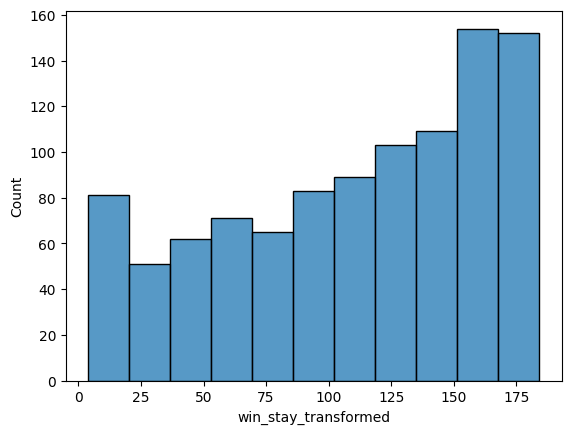

In [49]:
#All further analyses will be done on this transformed variable
pt=PowerTransformer(method='yeo-johnson', standardize=False)
skl_yeojohnson=pt.fit(pd.DataFrame(task_summary.win_stay))
skl_yeojohnson=pt.transform(pd.DataFrame(task_summary.win_stay))
task_summary['win_stay_transformed'] = pt.transform(pd.DataFrame(task_summary.win_stay))
sns.histplot(data=task_summary['win_stay_transformed'])

In [50]:
##most basic model
data=task_summary
formula = 'win_stay_transformed ~ block_type'
basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

In [51]:
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [52]:
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [53]:
#error message so commented out
#feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)

In [54]:
#error message so commented out
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)

    basic_model     feedback_randint     fractals_randint  \
0  10654.776639  CONVERGENCE WARNING  CONVERGENCE WARNING   

  feedback_fractals_randint     randslope  feedback_randint_randslope  \
0              NOT CONVERGE  10686.800039                10693.727599   

  feedback_fractals_randint_randslope  
0                        NOT CONVERGE  


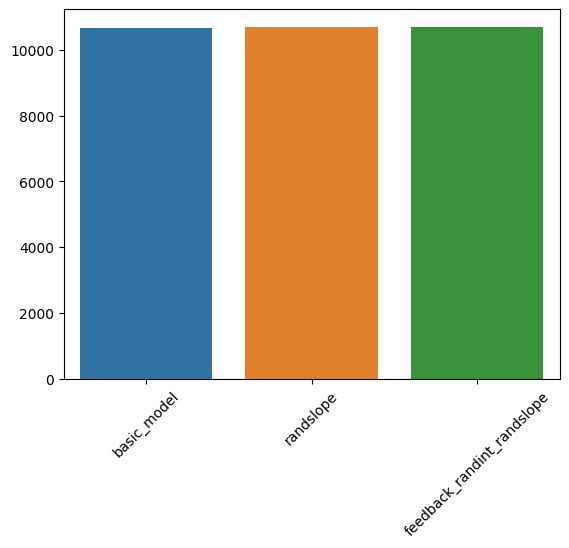

In [55]:
#test which random effects to include
#feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False) CONVERGENCE WARNING
#fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
#feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False) FAILED TO CONVERGE
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False) FAILED TO CONVERGE


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_randint': ['CONVERGENCE WARNING'], 
                    'fractals_randint': ['CONVERGENCE WARNING'],
                    'feedback_fractals_randint': ['NOT CONVERGE'], 
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope.bic],
                    'feedback_fractals_randint_randslope': ['NOT CONVERGE']})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, basic model wins

   age_covariate  no_covariate  sex_age_covariate  sex_covariate  \
0   10652.959552  10654.776639       10657.845179    10659.53567   

   digit_span_age_covariate  digit_span_covariate  \
0              10659.639877          10660.838919   

   sex_age_digit_span_covariate  sex_digit_span_covariate  
0                  10664.663371              10665.885164  


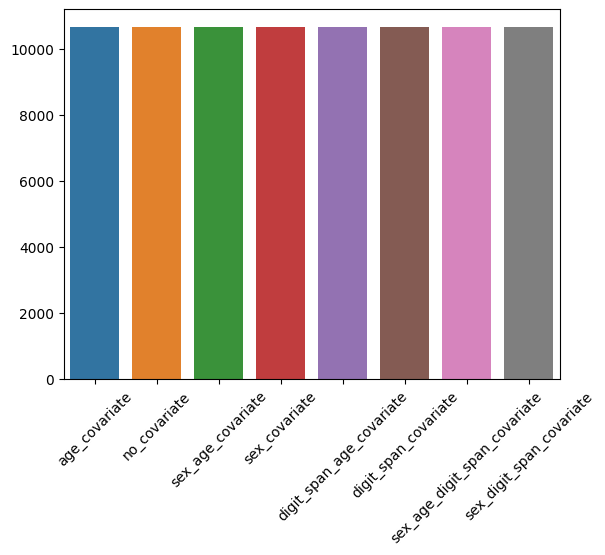

In [56]:
##test which covariates to add -- Using the random effects which were best above 
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})

plt.xticks(rotation=45) 
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, age covariate is best

In [57]:
#hypothesis test
age_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:            MixedLM Dependent Variable: win_stay_transformed
No. Observations: 1020    Method:             ML                  
No. Groups:       340     Scale:              1039.4970           
Min. group size:  3       Log-Likelihood:     -5305.6971          
Max. group size:  3       Converged:          Yes                 
Mean group size:  3.0                                             
------------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z| [0.025  0.975]
------------------------------------------------------------------
Intercept              89.746    8.173 10.981 0.000 73.728 105.764
block_type[T.Fear]     -1.240    2.473 -0.501 0.616 -6.086   3.607
block_type[T.Points]   -1.491    2.473 -0.603 0.547 -6.337   3.356
prolific_age            0.507    0.170  2.976 0.003  0.173   0.840
Group Var            1872.375    6.465                            
==================================================================

"""

In [58]:
#hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:             MixedLM Dependent Variable: win_stay_transformed
No. Observations:  1020    Method:             ML                  
No. Groups:        340     Scale:              1039.4992           
Min. group size:   3       Log-Likelihood:     -5310.0694          
Max. group size:   3       Converged:          Yes                 
Mean group size:   3.0                                             
-------------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------
Intercept             112.458    2.955 38.052 0.000 106.665 118.250
block_type[T.Fear]     -1.240    2.473 -0.501 0.616  -6.086   3.607
block_type[T.Points]   -1.491    2.473 -0.603 0.547  -6.337   3.356
Group Var            1930.173    6.633                             
===================================================================

"""

Test the assumptions of this model

In [59]:
#again checking assumptions

#chose model
results=age_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9975892480030629
p-value 0.13936987905953396
LM Statistic 4.33424895515879
LM-Test p-value 0.6315416360898078
F-Statistic 0.7204788562016422
F-Test p-value 0.6331641085900357


Also calculate Bayes factor for strenght of null

In [60]:
bayes_factor(task_summary, 'win_stay_transformed', 'Disgust', 'Points')

13.698630136986303

In [61]:
bayes_factor(task_summary, 'win_stay_transformed', 'Disgust', 'Fear')

14.705882352941176

In [62]:
bayes_factor(task_summary, 'win_stay_transformed', 'Fear', 'Points')

16.39344262295082

<b> MODEL 6: LOSE-SHIFT </b>

lose-shift  skew: 0.16189569452640257


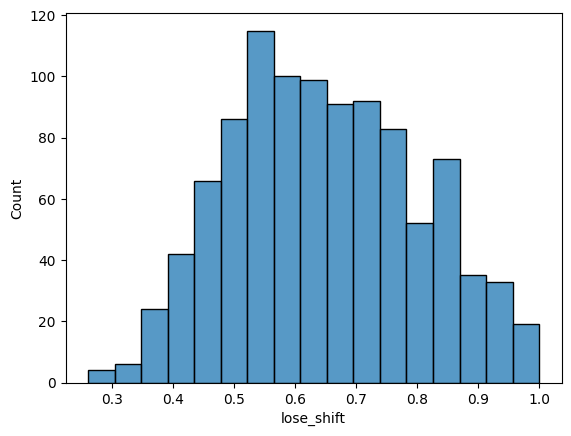

In [63]:
#check for skewness
sns.histplot(data=task_summary, x="lose_shift") 
print('lose-shift  skew: '+str(skew(task_summary.lose_shift, nan_policy='omit')))

Now run the hypothesis testing model

In [64]:
formula = 'lose_shift ~ block_type'
basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

In [65]:
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [66]:
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [67]:
feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [68]:
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [69]:
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [70]:
#error message so commented out
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)

   basic_model     feedback_randint     fractals_randint  \
0 -1288.060284  CONVERGENCE WARNING  CONVERGENCE WARNING   

  feedback_fractals_randint            randslope feedback_randint_randslope  \
0       CONVERGENCE WARNING  CONVERGENCE WARNING        CONVERGENCE WARNING   

  feedback_fractals_randint_randslope  
0                       NOT CONVERGED  


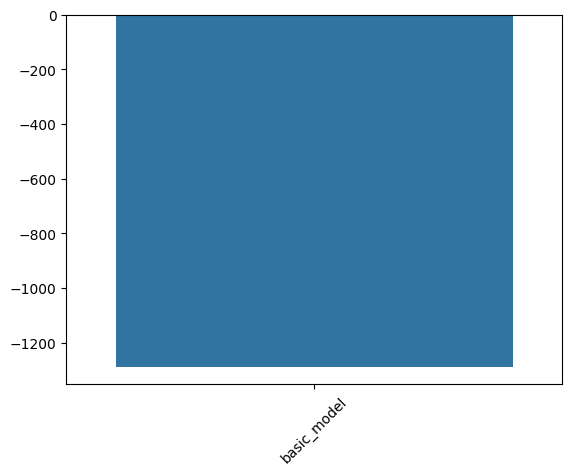

In [71]:
#test which random effects to include
#feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
#fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
#feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
        #had to comment out because it does not converge and errors out

#randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
#feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_randint': ['CONVERGENCE WARNING'], 
                    'fractals_randint': ['CONVERGENCE WARNING'],
                    'feedback_fractals_randint': ['CONVERGENCE WARNING'], 
                    'randslope': ['CONVERGENCE WARNING'],
                    'feedback_randint_randslope':['CONVERGENCE WARNING'],
                    'feedback_fractals_randint_randslope': ['NOT CONVERGED']})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, it is the most basic model

   age_covariate  no_covariate  digit_span_covariate  \
0   -1288.535949  -1288.060284          -1281.850289   

   digit_span_age_covariate  sex_age_covariate  sex_covariate  \
0              -1281.808445       -1281.615594   -1281.133448   

   sex_digit_span_covariate  sex_age_digit_span_covariate  
0              -1274.939687                   -1274.90024  


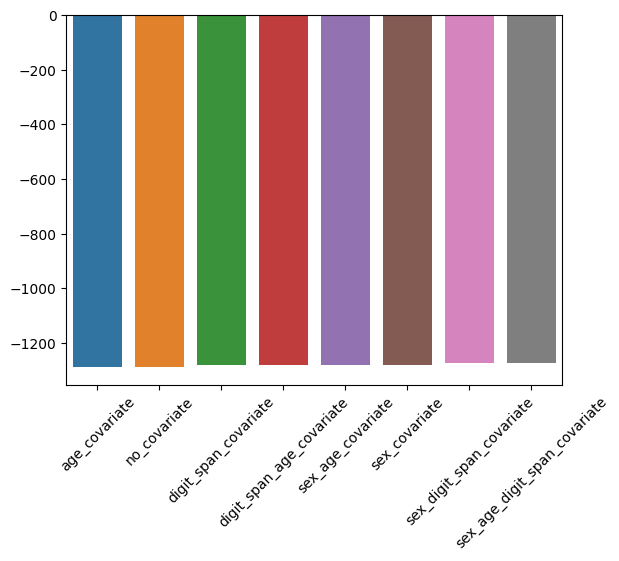

In [72]:
##test which covariates to add -- Using the random effects which were best above (basic model in this case)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
plt.xticks(rotation=45) 
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, age covariate is best

In [73]:
#hypothesis test
age_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM   Dependent Variable:   lose_shift
No. Observations:   1020      Method:               ML        
No. Groups:         340       Scale:                0.0089    
Min. group size:    3         Log-Likelihood:       665.0506  
Max. group size:    3         Converged:            Yes       
Mean group size:    3.0                                       
--------------------------------------------------------------
                     Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.578    0.023 25.522 0.000  0.533  0.622
block_type[T.Fear]   0.011    0.007  1.467 0.142 -0.004  0.025
block_type[T.Points] 0.027    0.007  3.743 0.000  0.013  0.041
prolific_age         0.001    0.000  2.736 0.006  0.000  0.002
Group Var            0.014    0.017                           
==============================================================

"""

In [74]:
#hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM   Dependent Variable:   lose_shift
No. Observations:   1020      Method:               ML        
No. Groups:         340       Scale:                0.0089    
Min. group size:    3         Log-Likelihood:       661.3490  
Max. group size:    3         Converged:            Yes       
Mean group size:    3.0                                       
--------------------------------------------------------------
                     Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.636    0.008 76.839 0.000  0.619  0.652
block_type[T.Fear]   0.011    0.007  1.467 0.142 -0.004  0.025
block_type[T.Points] 0.027    0.007  3.743 0.000  0.013  0.041
Group Var            0.014    0.017                           
==============================================================

"""

Test the assumptions of this model

In [75]:
#again checking assumptions

#chose model
results=age_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9982479633219511
p-value 0.3850884723504157
LM Statistic 7.570756342604826
LM-Test p-value 0.2712665370232574
F-Statistic 1.2625040586134841
F-Test p-value 0.27200186565651013


Calculate Bayes factor (if there is a null)

In [76]:
bayes_factor(task_summary, 'lose_shift', 'Disgust', 'Fear')

6.172839506172839

In [77]:
bayes_factor(task_summary, 'lose_shift', 'Points', 'Fear')

1.1013215859030836

<b>Finally (!) may also test the impact of adding video ratings to these analyses </b>
<p>This is very similar to models 3 and 4, i.e., is contingent on video rating analysis

In [78]:
data=task_summary.reset_index()

formula = 'win_stay_transformed ~ block_type + valence_diff + arousal_diff + valence_habdiff'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

In [79]:
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [80]:
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [81]:
#commented out due to error message
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)

    basic_model     feedback_randint     fractals_randint  \
0  10674.320476  CONVERGENCE WARNING  CONVERGENCE WARNING   

   feedback_fractals_randint     randslope  \
0               11110.274675  10706.429455   

                          feedback_randint_randslope  \
0  <statsmodels.regression.mixed_linear_model.Mix...   

  feedback_fractals_randint_randslope  
0                        NOT CONVERGE  


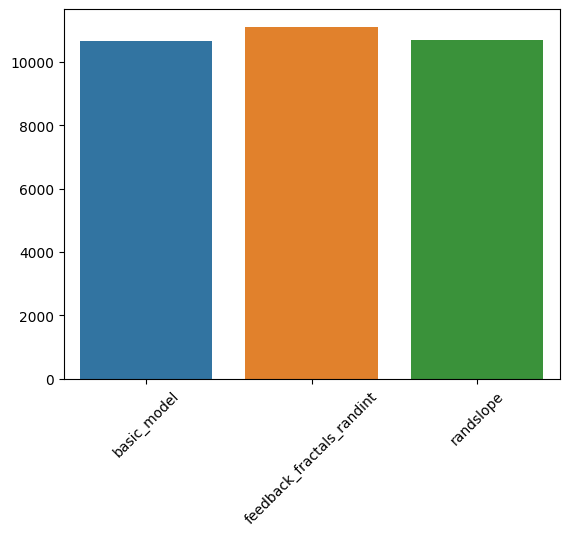

In [82]:
#test which random effects to include
#feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False) CONVERGENCE WARNING
#fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False) CONVERGENCE WARNING
feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False) 
        #had to comment out because it does not converge and errors out

randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False) 
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False) 
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False) NOT CONVERGE


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_randint': ['CONVERGENCE WARNING'], 
                    'fractals_randint': ['CONVERGENCE WARNING'],
                    'feedback_fractals_randint': [feedback_fractals_randint.bic], ##added manually
                    'randslope': [randslope.bic],
                    'feedback_randint_randslope':[feedback_randint_randslope],
                    'feedback_fractals_randint_randslope': ['NOT CONVERGE']})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, basic model

   age_covariate  no_covariate  sex_age_covariate  sex_covariate  \
0   10673.131274  10674.320476       10677.939294   10678.981914   

   digit_span_age_covariate  digit_span_covariate  \
0              10679.744339          10680.319189   

   sex_age_digit_span_covariate  sex_digit_span_covariate  
0                  10684.713948              10685.286736  


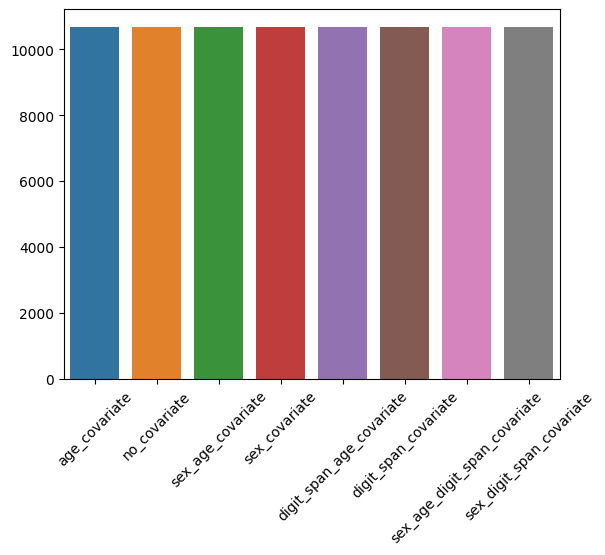

In [83]:
##test which covariates to add -- Using the random effects which were best above 
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
plt.xticks(rotation=45) 
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, age covariate is best

In [84]:
#so hypothesis test on the age covariate model
age_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:            MixedLM Dependent Variable: win_stay_transformed
No. Observations: 1020    Method:             ML                  
No. Groups:       340     Scale:              1039.4968           
Min. group size:  3       Log-Likelihood:     -5305.3916          
Max. group size:  3       Converged:          Yes                 
Mean group size:  3.0                                             
------------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z| [0.025  0.975]
------------------------------------------------------------------
Intercept              91.475    8.465 10.807 0.000 74.884 108.065
block_type[T.Fear]     -1.240    2.473 -0.501 0.616 -6.086   3.607
block_type[T.Points]   -1.491    2.473 -0.603 0.547 -6.337   3.356
valence_diff            1.262    1.639  0.770 0.441 -1.951   4.475
arousal_diff           -0.074    2.197 -0.034 0.973 -4.380   4.232
valence_habdiff        -0.219    1.247 -0.175 0.861 -2.663   2.225
prolific_age            0.493    0.172  2.866 0.004  0.156   0.831
Group Var            1868.392    6.453                            
==================================================================

"""

In [85]:
#redo with no covariates
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:             MixedLM Dependent Variable: win_stay_transformed
No. Observations:  1020    Method:             ML                  
No. Groups:        340     Scale:              1039.4988           
Min. group size:   3       Log-Likelihood:     -5309.4500          
Max. group size:   3       Converged:          Yes                 
Mean group size:   3.0                                             
-------------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------
Intercept             113.594    3.512 32.345 0.000 106.711 120.477
block_type[T.Fear]     -1.240    2.473 -0.501 0.616  -6.086   3.607
block_type[T.Points]   -1.491    2.473 -0.603 0.547  -6.337   3.356
valence_diff            1.624    1.654  0.982 0.326  -1.618   4.866
arousal_diff            0.560    2.212  0.253 0.800  -3.775   4.896
valence_habdiff        -0.063    1.261 -0.050 0.960  -2.534   2.407
Group Var            1921.895    6.609                             
===================================================================

"""

In [86]:
#again checking assumptions

#chose model
results=age_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9975463051132777
p-value 0.1298893515587406
LM Statistic 14.667815295792781
LM-Test p-value 0.9301030557168437
F-Statistic 0.6048778553564984
F-Test p-value 0.9326863876596916


Same for lose-shift

In [87]:
formula = 'lose_shift ~ block_type + valence_diff + arousal_diff + valence_habdiff'

basic_model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)

In [88]:
feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [89]:
fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [90]:
feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [91]:
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [92]:
feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [93]:
#error message so commented out
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)

   basic_model     feedback_randint     fractals_randint  \
0  -1269.68479  CONVERGENCE WARNING  CONVERGENCE WARNING   

  feedback_fractals_randint            randslope feedback_randint_randslope  \
0       CONVERGENCE WARNING  CONVERGENCE WARNING        CONVERGENCE WARNING   

  feedback_fractals_randint_randslope  
0                        NOT CONVERGE  


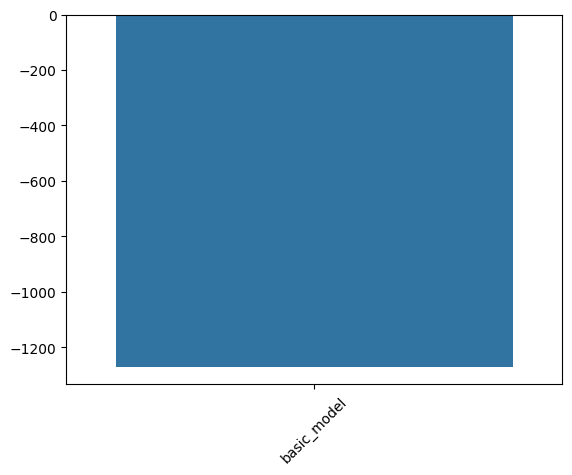

In [94]:
#test which random effects to include
#feedback_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}).fit(reml=False)
#fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'fractals': '0+fractals'}).fit(reml=False)
#feedback_fractals_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={"feedback_details": "0 + feedback_details", "fractals": "0 + fractals"}).fit(reml=False)
       

#randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~block_type').fit(reml=False)
#feedback_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details'}, re_formula='~block_type').fit(reml=False)
#feedback_fractals_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'feedback_details': '0+feedback_details', "fractals": "0 + fractals"}, re_formula='~block_type').fit(reml=False)


bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'feedback_randint': ['CONVERGENCE WARNING'], 
                    'fractals_randint': ['CONVERGENCE WARNING'],
                    'feedback_fractals_randint': ['CONVERGENCE WARNING'], 
                    'randslope': ['CONVERGENCE WARNING'],
                    'feedback_randint_randslope':['CONVERGENCE WARNING'],
                    'feedback_fractals_randint_randslope': ['NOT CONVERGE']})
sns.barplot(bic)
plt.xticks(rotation=45) 
print(bic) ##in this case, basic model is the best

   age_covariate  no_covariate  digit_span_covariate  \
0   -1269.938873   -1269.68479          -1263.947126   

   digit_span_age_covariate  sex_age_covariate  sex_covariate  \
0              -1263.521928        -1263.01444   -1262.757291   

   sex_digit_span_covariate  sex_age_digit_span_covariate  
0              -1257.035454                  -1256.614644  


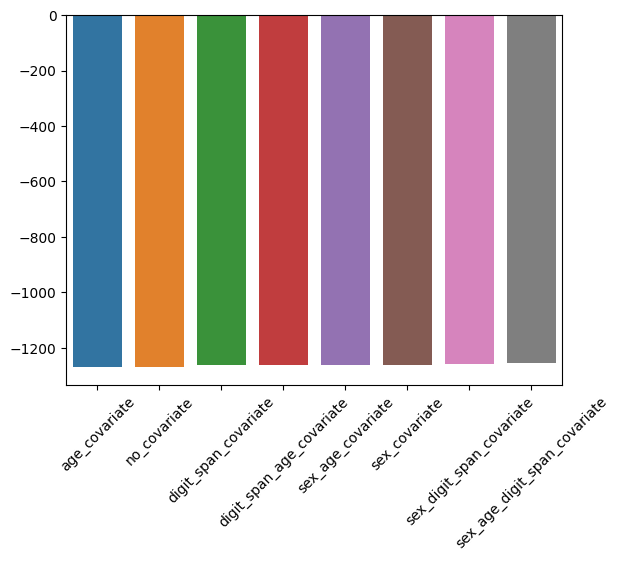

In [95]:
##test which covariates to add -- Using the random effects which were best above 
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_covariate=smf.mixedlm(formula+str('+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
digit_span_age_covariate=smf.mixedlm(formula+str('+digit_span+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_digit_span_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age+digit_span'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'digit_span_covariate': [digit_span_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic],
                    'sex_digit_span_covariate': [sex_digit_span_covariate.bic],
                    'digit_span_age_covariate': [digit_span_age_covariate.bic],
                    'sex_age_digit_span_covariate': [sex_age_digit_span_covariate.bic]})
plt.xticks(rotation=45)
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, age wins

In [96]:
#hypothesis test
age_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM   Dependent Variable:   lose_shift
No. Observations:    1020      Method:               ML        
No. Groups:          340       Scale:                0.0089    
Min. group size:     3         Log-Likelihood:       666.1434  
Max. group size:     3         Converged:            Yes       
Mean group size:     3.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.585    0.023 24.989 0.000  0.539  0.630
block_type[T.Fear]    0.011    0.007  1.467 0.142 -0.004  0.025
block_type[T.Points]  0.027    0.007  3.743 0.000  0.013  0.041
valence_diff          0.005    0.005  1.150 0.250 -0.004  0.014
arousal_diff         -0.002    0.006 -0.302 0.763 -0.014  0.010
valence_habdiff      -0.004    0.003 -1.269 0.205 -0.011  0.002
prolific_age          0.001    0.000  2.694 0.007  0.000  0.002
Group Var             0.014    0.017                           
===============================================================

"""

In [97]:
#hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM   Dependent Variable:   lose_shift
No. Observations:    1020      Method:               ML        
No. Groups:          340       Scale:                0.0089    
Min. group size:     3         Log-Likelihood:       662.5526  
Max. group size:     3         Converged:            Yes       
Mean group size:     3.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.642    0.010 65.670 0.000  0.623  0.661
block_type[T.Fear]    0.011    0.007  1.467 0.142 -0.004  0.025
block_type[T.Points]  0.027    0.007  3.743 0.000  0.013  0.041
valence_diff          0.006    0.005  1.348 0.178 -0.003  0.015
arousal_diff         -0.000    0.006 -0.030 0.976 -0.012  0.012
valence_habdiff      -0.004    0.003 -1.141 0.254 -0.011  0.003
Group Var             0.014    0.017                           
===============================================================

"""

In [98]:
#final check of model assumptions
#chose model
results=age_covariate

#shapiro-Wilk test of normality of residuals
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(results.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)
    ##if test is significant then the assumption is violated
        #is significant here

##homoskedasticity of variance 
#White Lagrange Multiplier Test for Heteroscedasticity
het_white_res = het_white(results.resid, results.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)
    ##again, only violated if you get a significant p value

Statistic 0.9982695081190501
p-value 0.39686218394380035
LM Statistic 43.866462882202946
LM-Test p-value 0.00790717266576318
F-Statistic 1.8630959506774885
F-Test p-value 0.007193987430433685


This model fails the homoskedasticity of variance test so a generalized mixed effects model needs to be run --> see <b>lose_shift_wVideoRatings.ipynb 

Example visualisations:

C:\Users\eb08\AppData\Local\Temp\ipykernel_17236\284131658.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
C:\Users\eb08\AppData\Local\Temp\ipykernel_17236\284131658.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)


Text(0.5, 1.0, 'Perseverative errors')

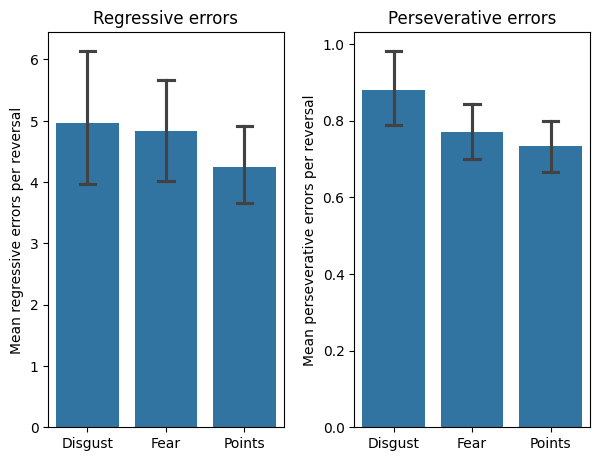

In [99]:
#Re-format for the poster
palette=["#FF9D1B", "#1E5DF8", "#00A788"] ##orange, blue, turquoise


##plot hypothesised results
fig, axes = plt.subplots(1,2, sharey=False)
#fig.set_size_inches(15, 5)
fig.tight_layout(pad=2)
pairs=[('Disgust', 'Fear'), ('Disgust', 'Points'), ('Fear', 'Points')]
order=['Disgust', 'Fear', 'Points']

n_comparisons=1
pvalue_thresholds=[0.0001/n_comparisons, "****"], [0.001/n_comparisons, "***"], [0.01/n_comparisons, "**"], [0.05/n_comparisons, "*"], [1, "ns"]

#sns.swarmplot(data=task_summary, x="block_type", y="mean_regressive_er", ax=axes[0], color=".5", size=5, )
sns.barplot(data=task_summary, x="block_type", y="mean_regressive_er", ax=axes[0], ci=95, fill=True, palette=sns.set_palette(palette, 3), capsize=.2)
#sns.barplot(data=task_summary, x="block_type", y="mean_regressive_er", ax=axes[0], ci=95, fill=False, color="0", capsize=.2)
#axes[0].set_xlabel("Feedback type")
axes[0].set_xlabel("")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].set_ylabel("Mean regressive errors per reversal") 
axes[0].set_title("Regressive errors") 


#sns.swarmplot(data=task_summary, x="block_type", y="mean_perseverative_er", ax=axes[1], color=".5", size=5)
sns.barplot(data=task_summary, x="block_type", y="mean_perseverative_er", ax=axes[1], ci=95, fill=True, palette=sns.set_palette(palette, 3), capsize=.2)
#axes[1].set_xlabel("Feedback type")
axes[1].set_xlabel("")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].set_ylabel("Mean perseverative errors per reversal") 
axes[1].set_title("Perseverative errors") 

C:\Users\eb08\AppData\Local\Temp\ipykernel_17236\1338769250.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
C:\Users\eb08\AppData\Local\Temp\ipykernel_17236\1338769250.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)


Text(0.5, 1.0, 'Lose-shift')

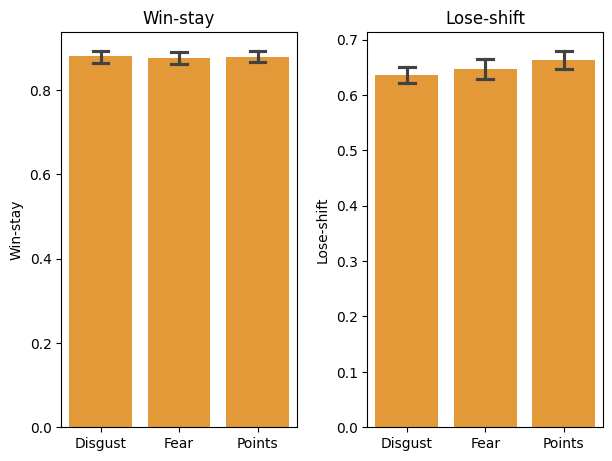

In [100]:
#Re-format for the poster
palette=["#FF9D1B", "#1E5DF8", "#00A788"] ##orange, blue, turquoise


##plot hypothesised results
fig, axes = plt.subplots(1,2, sharey=False)
#fig.set_size_inches(15, 5)
fig.tight_layout(pad=2)
pairs=[('Disgust', 'Fear'), ('Disgust', 'Points'), ('Fear', 'Points')]
order=['Disgust', 'Fear', 'Points']

n_comparisons=1
pvalue_thresholds=[0.0001/n_comparisons, "****"], [0.001/n_comparisons, "***"], [0.01/n_comparisons, "**"], [0.05/n_comparisons, "*"], [1, "ns"]

#sns.swarmplot(data=task_summary, x="block_type", y="win_stay", ax=axes[0], color=".5", size=5, )
sns.barplot(data=task_summary, x="block_type", y="win_stay", ax=axes[0], ci=95, fill=True, palette=sns.set_palette(palette, 3), capsize=.2)
#sns.barplot(data=task_summary, x="block_type", y="win_stay", ax=axes[0], ci=95, fill=False, color="0", capsize=.2)
#axes[0].set_xlabel("Feedback type")
axes[0].set_xlabel("")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].set_ylabel("Win-stay") 
axes[0].set_title("Win-stay") 


#sns.swarmplot(data=task_summary, x="block_type", y="lose_shift", ax=axes[1], color=".5", size=5)
sns.barplot(data=task_summary, x="block_type", y="lose_shift", ax=axes[1], ci=95, fill=True, palette=sns.set_palette(palette, 3), capsize=.2)
#axes[1].set_xlabel("Feedback type")
axes[1].set_xlabel("")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].set_ylabel("Lose-shift") 
axes[1].set_title("Lose-shift") 